<a href="https://colab.research.google.com/github/robincccc/ITP-487-Final-Takehome/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GROUP MEMBER:**
# Robin Chen

# Vivian(Mengmeng) Wang

# **Question 1:** 
**What does "counterfactual" mean?**

  "Counterfactual" refers to a claim, hypothesis, or other belief that has never happened, aka contrast to the facts. It is usually used as a predicted control group to test the effect of certain policy.

**What are three insights you gained from watching the video?**
  1. Interrupted Time Series mentioned in the talk was a common type of time series data used in business world. It is usually used to measure the effect of certain policy change. One of the method I learned in econometrics to measure this effect is called difference in differences, where the the interrupted time series data are compared with a conterfactual predicted time series data to get the approximated policy effect.
  2. In the latter part of the lecture, the speaker talks about how confounding varibales, which means causal factors that we have not observed yet, can also affect our experimental outcome. This is one of the major problem with every model. Chances are there will always be a few confounding variables that the model does not include, and if we are to add more covariates to the model, it might lead to the problem of overfitting. So to find a balance between model accuracy and complexity is a tricky process.
  3. After going through the entire lecture, I was shocked by how various regression models and methods can be applied to the interrupted time series data. For example, towards the end of the lecture, one of the audiences suggested to use another TV channel as a control group to solve the TV campaign. This method hasn't occur to me yet and can actually work if we manage to locate a similar channel. 

In [ ]:
# Import libraries
import pandas as pd 
import matplotlib.pyplot as plt
from plotnine import * # from plotnine library import all functions
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf

# **Question 2:** 

**Import the data from Nenana1.csv in python and call it df.** 

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/robertasgabrys/Forecasting/main/Nenana1.csv",sep='.')
df.head()

,"Year,Date & Time"
0,"1917,April 30 at 11:30 AM"
1,"1918,May 11 at 9:33 AM"
2,"1919,May 3 at 2:33 PM"
3,"1920,May 11 at 10:46 AM"
4,"1921,May 11 at 6:42 AM"


# **Question 3:** 


**Create a KPI (key performance indicator) to assess the global warming hypothesis by measuring the amount of time in days between the moment the ice breaks in Nenana (as recorded in the Nenana Ice Classic contest) and January 1st of each year.**

In [ ]:
df['dateTime'] = pd.to_datetime(df['Year,Date & Time'])
df['Year'] = df['dateTime'].dt.year
df.head()
df.tail()

,"Year,Date & Time",dateTime,Year
82,"1999,April 29 at 9:47 PM",1999-04-29 21:47:00,1999
83,"2000,May 1 at 10:47 AM",2000-05-01 10:47:00,2000
84,"2001,May 8 at 1:00 PM",2001-05-08 13:00:00,2001
85,"2002,May 7 at 9:27 PM",2002-05-07 21:27:00,2002
86,"2003,April 29 at 6:22 PM",2003-04-29 18:22:00,2003


In [ ]:
df['January1'] = df['Year'].apply(lambda x:dt.datetime(x,1,1))
df.head()

,"Year,Date & Time",dateTime,Year,January1
0,"1917,April 30 at 11:30 AM",1917-04-30 11:30:00,1917,1917-01-01
1,"1918,May 11 at 9:33 AM",1918-05-11 09:33:00,1918,1918-01-01
2,"1919,May 3 at 2:33 PM",1919-05-03 14:33:00,1919,1919-01-01
3,"1920,May 11 at 10:46 AM",1920-05-11 10:46:00,1920,1920-01-01
4,"1921,May 11 at 6:42 AM",1921-05-11 06:42:00,1921,1921-01-01


In [ ]:
# KPI = amount of time in days beweet January 1 and the time ice broke
# We wil use  timedelta function that provides us with the amount of time between two dates
df['KPI'] = pd.to_timedelta(df['dateTime']-df['January1']).dt.total_seconds()/(24*60*60)
df.head()

,"Year,Date & Time",dateTime,Year,January1,KPI
0,"1917,April 30 at 11:30 AM",1917-04-30 11:30:00,1917,1917-01-01,119.479167
1,"1918,May 11 at 9:33 AM",1918-05-11 09:33:00,1918,1918-01-01,130.397917
2,"1919,May 3 at 2:33 PM",1919-05-03 14:33:00,1919,1919-01-01,122.606250
3,"1920,May 11 at 10:46 AM",1920-05-11 10:46:00,1920,1920-01-01,131.448611
4,"1921,May 11 at 6:42 AM",1921-05-11 06:42:00,1921,1921-01-01,130.279167


# **Question 4:** 

**Create a line graph utilizing the KPI defined as the amount of time in days between the moment ice breaks in Nenana and January 1 of each year. Additionally, include a vertical line to represent the hypothesized year of global warming, 1960, and create separate regression lines for data prior to and after 1960. What information can be inferred from this graph?**

In [ ]:
df['BM'] = 'Before'
df.loc[43:,'BM'] = 'After'

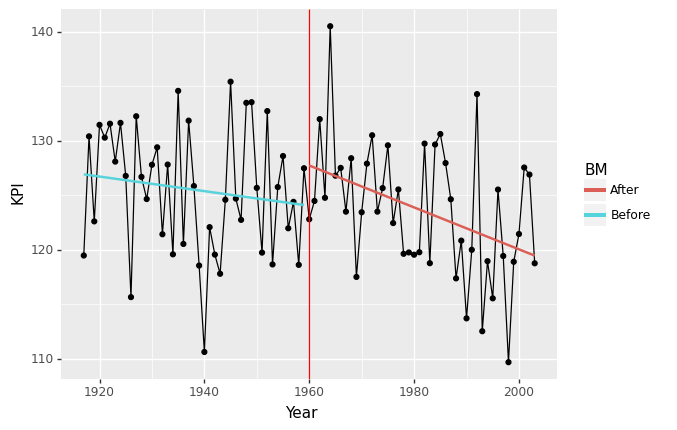

<ggplot: (8750159629451)>

In [ ]:
# Question 4: line graph  
ggplot(df,aes("Year","KPI")) + geom_point() + geom_line() + geom_vline(xintercept=df.loc[43,'Year'],color='red') + geom_smooth(aes(color='BM'),method='lm',se=False)

**Answer:**

From the plot we can see that both before and after 1960, the time between ice breaks in Nenana and January 1 are generally decreasing. However, judging by the slope of the linear regressions before and after 1960, we can see clearly that the slope of the regression after 1960 is lower than that before 1960, meaning that we intuitively think that the time the ice in Nenana melted became eariler year over year, and the acceleration increased after 1960.

# **Question 5:** 
**Does the data provide statistically significant evidence of global warming?** 

# **Abrupt change point detection:**
**a. Carry out a 2 sample t test and interpret the results:**

In [ ]:
# H0: Global warming did NOT start since 1960. mu_B <= mu_A
# H1: Global warming started since 1960. mu_B > mu_A
# where mu_B = average KPI Before 1960; mu_A = average KPI After 1960
# After setting our siginificance level (alpha) at 5%, we conducted the following 2 sample t test:
ttest_ind(a = df.loc[:42,'KPI'], b = df.loc[43:,'KPI'] , axis=0, equal_var=False, alternative='greater')

Ttest_indResult(statistic=1.515355706530577, pvalue=0.06669684234330425)

**Conclusion:**

since the p-value (0.06669) > alpha(0.05), the data does not provide statistically significant evidence that global warming starts in 1960. So we conclude that global warming did not start in 1960.

**b. By what percent the mean value of the KPI changed after 1960?**

In [ ]:
(df.loc[43:, 'KPI'].mean() - df.loc[:42, 'KPI'].mean())/df.loc[:42, 'KPI'].mean()*100

-1.5235680856001192

**Answer:**

The mean value of KPI changed by -1.523% after 1960.


**c. Create a dummy variable and build a regression model and interpret the results.**

In [ ]:
# Here we use BM as our dummy varrable.
M2 = smf.ols('KPI ~ BM',data = df).fit()
print(M2.summary())

                            OLS Regression Results                            
Dep. Variable:                    KPI   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.294
Date:                Mon, 06 Feb 2023   Prob (F-statistic):              0.134
Time:                        03:28:14   Log-Likelihood:                -276.67
No. Observations:                  87   AIC:                             557.3
Df Residuals:                      85   BIC:                             562.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      123.5988      0.888    139.251   

**Interpretation:**


Model: KPI = 123.5988 + 1.9122 * BM

BM = 1 for data Before, and 0 for data After

For data After BM = 0 -> KPI = 123.5988 + 1.9122 * BM = 123.5988 + 1.9122 * 0 = 123.5988 = average KPI after 1960

For data Before BM = 1 -> KPI = 123.5988 + 1.9122 * BM = 123.5988 + 1.9122 * 1= 125.511 = average KPI before 1960

**d. Provide a visual representation of the results of a two sample t test and regression model applied to data and evaluate the adequacy and accuracy of these models in capturing the data.**


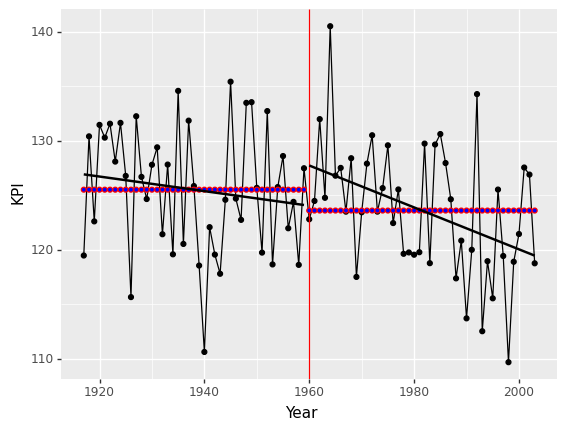

<ggplot: (8750159544254)>

In [ ]:
# Create extra columns M1 and M2 to represent the 2 sample t test and the regression.
df['M1'] = df.loc[:42,'KPI'].mean()
df.loc[43:,'M1'] = df.loc[43:,'KPI'].mean()
df['M2'] = M2.fittedvalues

ggplot(df,aes('Year','KPI')) + geom_point() +  geom_line() + geom_vline(xintercept=df.loc[43,'Year'],color='red') + geom_point(aes('Year','M1'),color='red') + geom_point(aes('Year','M2'),color='blue',size=0.5) + geom_smooth(aes(group='BM'), method='lm',se=False)

**Answer:** 

Since both the 2 sample test and the OLS model yield the same result, it is reasonable to analyze their accuracy together. From the model's summary, we can see that the coefficient for BM has a high p-value, meaning that is not statistically significant. Also, the model generates a R-squared value of 0.026, meaning that only a small portion of the data is explained by the model, making the accuarcy of the model relatively poor.

# **Gradual change point detection:** 

**e. Create a ramp variable and build a regression model and interpret the results.**


In [ ]:
df['Ramp'] = 0
df.loc[43:,'Ramp'] = range(1,45)
df.tail(44)

,"Year,Date & Time",dateTime,Year,January1,KPI,BM,M1,M2,Ramp
43,"1960,May 2 at 7:12 PM",1960-05-02 19:12:00,1960,1960-01-01,122.800000,After,123.598832,123.598832,1
44,"1961,May 5 at 11:31 AM",1961-05-05 11:31:00,1961,1961-01-01,124.479861,After,123.598832,123.598832,2
45,"1962,May 12 at 11:23 PM",1962-05-12 23:23:00,1962,1962-01-01,131.974306,After,123.598832,123.598832,3
46,"1963,May 5 at 6:25 PM",1963-05-05 18:25:00,1963,1963-01-01,124.767361,After,123.598832,123.598832,4
47,"1964,May 20 at 11:41 AM",1964-05-20 11:41:00,1964,1964-01-01,140.486806,After,123.598832,123.598832,5
48,"1965,May 7 at 7:01 PM",1965-05-07 19:01:00,1965,1965-01-01,126.792361,After,123.598832,123.598832,6
49,"1966,May 8 at 12:11 PM",1966-05-08 12:11:00,1966,1966-01-01,127.507639,After,123.598832,123.598832,7
50,"1967,May 4 at 11:55 AM",1967-05-04 11:55:00,1967,1967-01-01,123.496528,After,123.598832,123.598832,8
51,"1968,May 8 at 9:26 AM",1968-05-08 09:26:00,1968,1968-01-01,128.393056,After,123.598832,123.598832,9
52,"1969,April 28 at 12:28 PM",1969-04-28 12:28:00,1969,1969-01-01,117.519444,After,123.598832,123.598832,10


In [ ]:
# Test our previous assumptions
df['Time'] = range(1,len(df)+1)
M5 =smf.ols('KPI ~ Time',data = df.loc[df['BM']=="Before"]).fit()
print(M5.summary())

                            OLS Regression Results                            
Dep. Variable:                    KPI   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8890
Date:                Mon, 06 Feb 2023   Prob (F-statistic):              0.351
Time:                        03:28:15   Log-Likelihood:                -135.35
No. Observations:                  43   AIC:                             274.7
Df Residuals:                      41   BIC:                             278.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    126.9817      1.791     70.907      0.0

**Conclusion:** 

Time is not significant (p-value(0.351)>alpha(0.05)), we will conclude that there is no statistically significant evidence against the assumption of absence of trend.

In [ ]:
# M3 captures gradual intervention
# Assume no trend in the data before year 1960
M3 =smf.ols('KPI ~ Ramp',data=df).fit()
print(M3.summary())

                            OLS Regression Results                            
Dep. Variable:                    KPI   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     9.069
Date:                Mon, 06 Feb 2023   Prob (F-statistic):            0.00342
Time:                        03:28:15   Log-Likelihood:                -273.42
No. Observations:                  87   AIC:                             550.8
Df Residuals:                      85   BIC:                             555.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    125.9884      0.774    162.675      0.0

**Interpretation:** 

Model: KPI = 125.9884 + -0.1269 * Ramp

Ramp: Ramp = 0,0,0,...,0,1,2,3,4,...

2 sample t test p-value for KPI = 0.1309657087185134

Ramp p-value in regression model = 0.003/2 = 0.0015.

Since p-value is less than 0.05, we conclude that the gradual effect of BM is statistically siginificant. Thus we can reject the Null hypothesis (H_0) and indicates that the global warming starts after 1960. 

**f. Build a regression model with a dummy variable and the ramp variable and interpret the results.**

In [ ]:
# M4 captures dummy and gradual intervention
M4 =smf.ols('KPI ~ BM + Ramp',data=df).fit() 
print(M4.summary())

                            OLS Regression Results                            
Dep. Variable:                    KPI   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     5.337
Date:                Mon, 06 Feb 2023   Prob (F-statistic):            0.00658
Time:                        03:28:15   Log-Likelihood:                -272.63
No. Observations:                  87   AIC:                             551.3
Df Residuals:                      84   BIC:                             558.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      127.9196      1.734     73.768   

**Interpretation:**

Model:  y = 127.9196 + BM * (-2.4085) + Ramp * (-0.1920)

The p-value of immediate effect is 0.217/2 = 0.1085. The p-value is greater than 0.05, which indicates that the effect is statistically insiginificant. And the p-value of the gradual effect is 0.005/2 = 0.0025 < 0.05, which proves that the effect is statisticallt siginificant.

Therefore, we conclude that the global warming is starting after 1960, but it is not causing an immediate effect.

**g. Provide a visual representation of the results of both regression models applied to data and evaluate the adequacy and accuracy of these models in capturing the data.**

In [ ]:
# Store M2, M3 and M4 models predicted/fitted values in columns M2, M3 and M4 in data
df['M3'] = M3.fittedvalues
df['M4'] = M4.fittedvalues
df.tail()

,"Year,Date & Time",dateTime,Year,January1,KPI,BM,M1,M2,Ramp,Time,M3,M4
82,"1999,April 29 at 9:47 PM",1999-04-29 21:47:00,1999,1999-01-01,118.907639,After,123.598832,123.598832,40,83,120.910883,120.238232
83,"2000,May 1 at 10:47 AM",2000-05-01 10:47:00,2000,2000-01-01,121.449306,After,123.598832,123.598832,41,84,120.783944,120.046198
84,"2001,May 8 at 1:00 PM",2001-05-08 13:00:00,2001,2001-01-01,127.541667,After,123.598832,123.598832,42,85,120.657005,119.854163
85,"2002,May 7 at 9:27 PM",2002-05-07 21:27:00,2002,2002-01-01,126.893750,After,123.598832,123.598832,43,86,120.530066,119.662129
86,"2003,April 29 at 6:22 PM",2003-04-29 18:22:00,2003,2003-01-01,118.765278,After,123.598832,123.598832,44,87,120.403127,119.470095


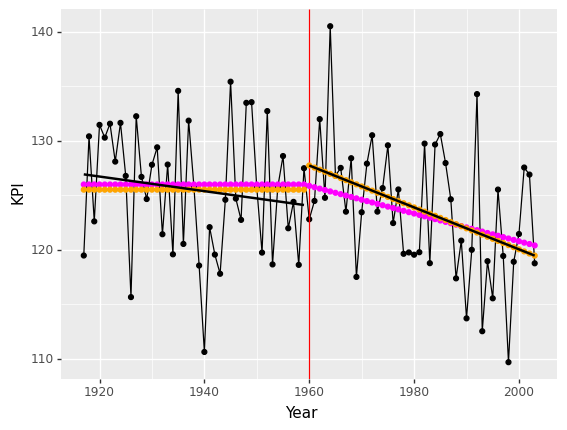

<ggplot: (8750159494033)>

In [ ]:
(
 ggplot(df,aes('Year','KPI')) + geom_point() +  geom_line() + 
 geom_vline(xintercept=df.loc[43,'Year'], color='red') +
 geom_point(aes('Year','M3'),color='magenta') +  
 geom_point(aes('Year','M4'),color='orange') + 
 geom_smooth(aes(group='BM'), method='lm',se=False)
)

**Answer:**

M3 model capture the gradual effect. The p-value for M3 of ramp is 0.003/2 = 0.0015, and r-square is 0.096. 

M4 model capture the ramp and the dummy effect. The p-value for M4 of ramp is 0.005/2 = 0.0025, and the r-square is 0.113. 

We can conclude that M4 is better the M3 since both model is statistically siginificant and M4 have a higher R-square value. Higher R-square means smaller differences between the observed data and the fitted values, proving that the model fits better.

Moreover, from the visilization above, we can see that M4, the orange one, indicates better results than the other one. Even though the BM effect in M4 is not siginificant, it won't hurt anything since it is a binary variable and will equal = 0 before year 1960. Therefore, including the binary variable will allows the slope of the line to be adjusted more accurately. It mathmetically allows the line to be more flexiable. 

# **Question 6:**

**What is the more appropriate effect of the intervention that started  in 1960, abrupt or gradual. Briefly explain your reasoning.**

**Answer:**

The more appropriate effect of the intervention that started in 1960 is gradual change point detection. Because when using the abrupt point detection, both 2-sample t test and regression model fails to detect any immediate effect that started in 1960. However, when using the gradul point detection, and under the assumption that there is no data trends before 1960, we successfully conclude that there is siginificant ramp global warming effect of started in 1960. Therefore, the gradul one is more appropriate.

# **Question 7:**


**Compare the results of the two-sample t-test performed on Batmobile data to the results obtained in 4.a, in which you conducted the analysis on Nenana data. Have you identified any intriguing or surprising observations?**


**Answer:**

From our two-sample-t-test on Nenana data, we see that its p-value is greater, but relatively closer to the alpha level of 0.05 when compared to the two-sample-t-test on Batmobile data, where the p-value reaches 0.9464, which is much higher. This is intriguing but also reasonable because in the batmobile data, we see more gradual change between the data after the implementation of the policy. The slope of the trend changed abrupted after the intervention and data points are also more spreadout. Those facters leads to a higher p-value, making us harder to accept the null hypothesis.

# **Question 8:**

**What are the key arguments and points made in both the original article by the two Stanford professors and the critique of the article, as well as the comments below the critique, and what is your brief commentary on the information presented in these articles?**


**Answer:**

From the article "Climate Change in Nontraditional Data Sets", Professor Sagarin and Professor Micheli analyzed the ice breaking event of Nenana. In their paper, they presume that the ice breaking was caused by mainly two reasons: thermal effect and dynamic effect. Then they used historical data from both Nenana and Fairbanks to illustrate their points of global warming taking place in recent decades. However, the critique of the article points out several defects. The critique points out that Nenana ice break can also be casued by urbanization of Fairbanks, a city located at the upstream of the tripod. The city's runoff and water usage might directly cause the ice temperature to increase and shorten the ice breaking time. Also, the critique points out that the data used in the article are only partial data collected from Nenana and Fairbanks, making the data flawed and eventually produce a false trend that leads to a completely biased conclusion. According to the critique, the temperature in Nenana didn't increase, but decreased over the past years as snowfall has increased significantly, which is contrary to the conclusion of global warming by the original article. In the critique's comment section, many people commented on how this study of climate change can be improved by including more data and supporting evidence of urbanization in Fairbanks. The author of the critique also replied to some of the comments and questions posted to improve the outcome.

For me, I think the original article might be too arbitrary to use partial data to analyze the historical trend of climate change. Also the inclusion of a few outliers in the dataset can also have substantial effect on the climate change modeling. In other words, I support the critique of the article and believe more precise conclusion can be drawed from better data selection and more detailed modeling.

# **Question 9:**

**The NASA National Snow and Ice Data Center recently updated the Nenana1.csv dataset to include more recent data, which is now available in the Nenana2.csv file. Perform both abrupt and gradual change point analyses using regression and  using the updated Nenana2.csv data. Does the updated data lead to different conclusions compared to the previous dataset? If there are any differences in conclusions, briefly explain why.**

In [ ]:
df1 = pd.read_csv("https://raw.githubusercontent.com/robertasgabrys/Forecasting/main/Nenana2.csv",sep='.')
df1.head()

,"Year,Date & Time"
0,"1917,April 30 at 11:30 AM"
1,"1918,May 11 at 9:33 AM"
2,"1919,May 3 at 2:33 PM"
3,"1920,May 11 at 10:46 AM"
4,"1921,May 11 at 6:42 AM"


In [ ]:
df1['dateTime'] = pd.to_datetime(df1['Year,Date & Time'])
df1['Year'] = df1['dateTime'].dt.year
df1.head()

,"Year,Date & Time",dateTime,Year
0,"1917,April 30 at 11:30 AM",1917-04-30 11:30:00,1917
1,"1918,May 11 at 9:33 AM",1918-05-11 09:33:00,1918
2,"1919,May 3 at 2:33 PM",1919-05-03 14:33:00,1919
3,"1920,May 11 at 10:46 AM",1920-05-11 10:46:00,1920
4,"1921,May 11 at 6:42 AM",1921-05-11 06:42:00,1921


In [ ]:
df1['January1'] = df1['Year'].apply(lambda x:dt.datetime(x,1,1))
df1.head()

,"Year,Date & Time",dateTime,Year,January1
0,"1917,April 30 at 11:30 AM",1917-04-30 11:30:00,1917,1917-01-01
1,"1918,May 11 at 9:33 AM",1918-05-11 09:33:00,1918,1918-01-01
2,"1919,May 3 at 2:33 PM",1919-05-03 14:33:00,1919,1919-01-01
3,"1920,May 11 at 10:46 AM",1920-05-11 10:46:00,1920,1920-01-01
4,"1921,May 11 at 6:42 AM",1921-05-11 06:42:00,1921,1921-01-01


In [ ]:
df1['KPI'] = pd.to_timedelta(df1['dateTime']-df1['January1']).dt.total_seconds()/(24*60*60)
#df1.head(45)

In [ ]:
df1.tail()

,"Year,Date & Time",dateTime,Year,January1,KPI
100,"2017,May 1 at 12:00 PM",2017-05-01 12:00:00,2017,2017-01-01,120.500000
101,"2018,May 1 at 1:18 PM",2018-05-01 13:18:00,2018,2018-01-01,120.554167
102,"2019,April 14 at 12:21 AM",2019-04-14 00:21:00,2019,2019-01-01,103.014583
103,"2020,April 27 at 12:56 PM",2020-04-27 12:56:00,2020,2020-01-01,117.538889
104,"2021,April 30 at 12:50 PM",2021-04-30 12:50:00,2021,2021-01-01,119.534722


In [ ]:
df1['BM'] = 'Before'
df1.loc[43:,'BM'] = 'After'
# df1.head(44)

# **Abrupt change point detection:**

In [ ]:
# H0: Global warming did NOT start since 1960. mu_B <= mu_A
# H1: Global warming started since 1960. mu_B > mu_A
# where mu_B = average KPI Before 1960; mu_A = average KPI After 1960
# Setting our siginificance level (alpha) at 5%

In [ ]:
# Abrupt Regression Model
M_abrupt = smf.ols('KPI ~ BM',data = df1).fit()
print(M_abrupt.summary())

                            OLS Regression Results                            
Dep. Variable:                    KPI   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     6.966
Date:                Mon, 06 Feb 2023   Prob (F-statistic):            0.00960
Time:                        03:28:17   Log-Likelihood:                -342.21
No. Observations:                 105   AIC:                             688.4
Df Residuals:                     103   BIC:                             693.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      122.1805      0.808    151.300   

**Interpretation:**

Model: KPI = 122.1805 + 3.3306 * BM

BM = 1 for data Before, and 0 for data After

For data After BM = 0 -> KPI = 122.1805 + 3.3306 * BM = 122.1805 + 3.3306 * 0 = 122.1805 = average KPI after 1960

For data Before BM = 1 -> KPI = 122.1805 + 3.3306 * BM = 122.1805 + 3.3306 * 1= 125.511 = average KPI before 1960

BM p-value in regression model = 0.01/2 = 0.005.
Since p-value is less than 0.05, we conclude that the abrupt effect of BM is statistically siginificant. We can reject the Null hypothesis (H_0) and indicates that the global warming starts after 1960.

# **Gradual change point detection:** 

In [ ]:
df1['Ramp'] = 0
df1.loc[43:,'Ramp'] = range(1,63)
#df1.head(44)

In [ ]:
# Assume no trend in the data before year 1960
M_gradual =smf.ols('KPI ~ Ramp',data=df1).fit()
print(M_gradual.summary())

                            OLS Regression Results                            
Dep. Variable:                    KPI   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     23.37
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           4.69e-06
Time:                        03:28:18   Log-Likelihood:                -334.91
No. Observations:                 105   AIC:                             673.8
Df Residuals:                     103   BIC:                             679.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    126.0571      0.778    162.027      0.0

**Interpretation:** 

Model: KPI = 126.0571 + -0.1351 * Ramp

Ramp: Ramp = 0,0,0,...,0,1,2,3,4,...

Ramp p-value in regression model = 0.000/2 = 0.000.

Since p-value is less than 0.05, we conclude that the gradual effect of BM is statistically siginificant. We can reject the Null hypothesis (H_0) and indicates that the global warming starts after 1960.

In [ ]:
M_dummy_ramp =smf.ols('KPI ~ BM + Ramp',data=df1).fit() 
print(M_dummy_ramp.summary())

                            OLS Regression Results                            
Dep. Variable:                    KPI   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     12.43
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           1.47e-05
Time:                        03:28:18   Log-Likelihood:                -334.19
No. Observations:                 105   AIC:                             674.4
Df Residuals:                     102   BIC:                             682.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      127.6092      1.522     83.840   

**Interpretation:**

Model:  y = 127.6092 + BM * (-2.0981) + Ramp * (-0.1723)

The p-value of immediate effect is 0.239/2 = 0.1195. The p-value is greater than 0.05, which indicates that the effect is statistically insiginificant. And the p-value of the gradual effect is 0.000/2 = 0.000 < 0.05, which proves that the effect is statisticallt siginificant.

Therefore, we conclude that the global warming is starting after 1960, but it is not causing an immediate effect.

In [ ]:
# Test our previous assumptions
df1['Time'] = range(1,len(df1)+1)
M_test =smf.ols('KPI ~ Time',data = df1.loc[df1['BM']=="Before"]).fit()
print(M_test.summary())

                            OLS Regression Results                            
Dep. Variable:                    KPI   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8890
Date:                Mon, 06 Feb 2023   Prob (F-statistic):              0.351
Time:                        03:28:18   Log-Likelihood:                -135.35
No. Observations:                  43   AIC:                             274.7
Df Residuals:                      41   BIC:                             278.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    126.9817      1.791     70.907      0.0

no statistically significant evidence against the assumption of absence of trend.

In [ ]:
df1['M_abrupt'] = M_abrupt.fittedvalues
df1['M_gradual'] = M_gradual.fittedvalues
df1['M_dummy_ramp'] = M_dummy_ramp.fittedvalues
df1.head()

,"Year,Date & Time",dateTime,Year,January1,KPI,BM,Ramp,Time,M_abrupt,M_gradual,M_dummy_ramp
0,"1917,April 30 at 11:30 AM",1917-04-30 11:30:00,1917,1917-01-01,119.479167,Before,0,1,125.511079,126.057114,125.511079
1,"1918,May 11 at 9:33 AM",1918-05-11 09:33:00,1918,1918-01-01,130.397917,Before,0,2,125.511079,126.057114,125.511079
2,"1919,May 3 at 2:33 PM",1919-05-03 14:33:00,1919,1919-01-01,122.606250,Before,0,3,125.511079,126.057114,125.511079
3,"1920,May 11 at 10:46 AM",1920-05-11 10:46:00,1920,1920-01-01,131.448611,Before,0,4,125.511079,126.057114,125.511079
4,"1921,May 11 at 6:42 AM",1921-05-11 06:42:00,1921,1921-01-01,130.279167,Before,0,5,125.511079,126.057114,125.511079


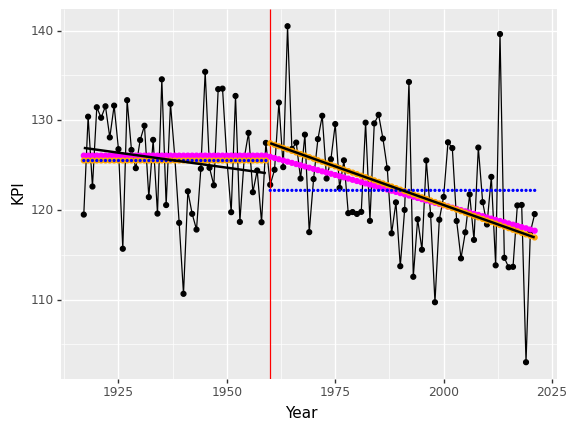

<ggplot: (8750159606532)>

In [ ]:
(
    ggplot(df1,aes('Year','KPI')) + geom_point() +  geom_line() + 
 geom_vline(xintercept=df1.loc[43,'Year'],color='red') +
 geom_point(aes('Year','M_gradual'),color='magenta') + 
 geom_point(aes('Year','M_dummy_ramp'),color='orange') +
geom_point(aes('Year','M_abrupt'),color='blue',size=0.3)+
geom_smooth(aes(group='BM'),method='lm',se=False)

)

**Comparison:**


The abrupt and gradual change point detection using the new datasets is similar to the previous one: the p-value for abrupt change point detection is not statistically siginificant, and the p-value for gradual change is satistically siginificant.


Therefore, there is no immediate effect after 1960, but there is gradual effect.


However, compared to the previous model based on the old datasets, the updated gradual model have both higher R-square and adjusted R-square values. It means that it is more effective and accurate, indicating that the inclusion of recent data points will yield a better result.
